In [1]:

#Import Libraries

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf 
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
print ("Done")

Done


In [2]:
Tess = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/'

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [3]:
Tess_df.to_csv("Tess_df.csv",index=False)
Tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


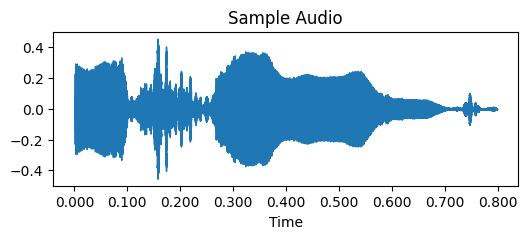

In [38]:
sample_data,sampling_rate = librosa.load(file_path[0], duration=2.5,offset=0.6)

# Plotting Sample Audio
plt.figure(figsize=(6, 2))
librosa.display.waveshow(y=sample_data)
plt.title('Sample Audio')
plt.savefig('Sample_Audio.png', dpi=1200)

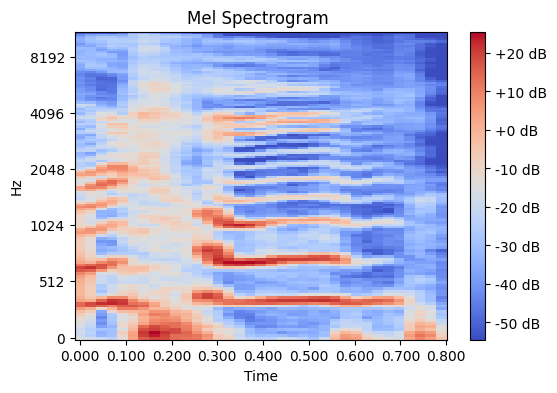

In [42]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(6, 4))
mel_spec = librosa.feature.melspectrogram(y=sample_data) 
mel_spec = librosa.power_to_db(mel_spec)
librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram ')
plt.savefig('Mel_Spec.png', dpi=1200)
plt.colorbar(format='%+2.0f dB')

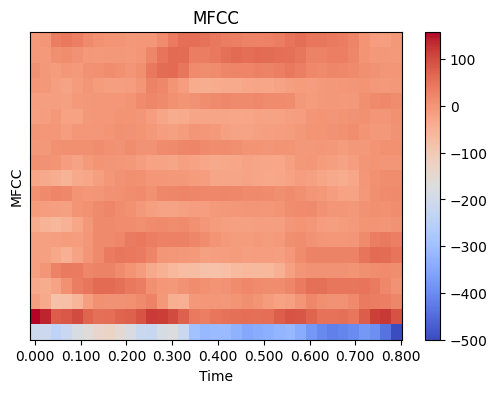

In [33]:
# CREATE MFCC
MFCC = librosa.feature.mfcc(y=sample_data)
plt.figure(figsize=(6, 4))
librosa.display.specshow(MFCC, x_axis='time')
plt.ylabel('MFCC')
plt.title('MFCC')
plt.savefig('MFCC.png', dpi=1200)
plt.colorbar()

In [37]:
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    return audio

In [38]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(Tess_df.Path,Tess_df.Emotions,range(Tess_df.Path.shape[0]))):
    tempo=get_features(path)
    features=np.empty((0,tempo.shape[0]), dtype=object)
    features=np.vstack([features,tempo])
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

16it [00:00, 72.82it/s]

0 audio has been processed


516it [00:07, 78.39it/s]

500 audio has been processed


1012it [00:14, 72.44it/s]

1000 audio has been processed


1512it [00:23, 63.84it/s]

1500 audio has been processed


2010it [00:30, 66.56it/s]

2000 audio has been processed


2508it [00:37, 66.51it/s]

2500 audio has been processed


2800it [00:41, 67.12it/s]

Done
Time:  41.72221169499994


In [39]:
len(X), len(Y), Tess_df.Path.shape

(2800, 2800, (2800,))

In [40]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2056         True
2057         True
2058         True
2059         True
Emotions    False
Length: 2061, dtype: bool


In [41]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2056        False
2057        False
2058        False
2059        False
Emotions    False
Length: 2061, dtype: bool


(2800, 2061)

In [71]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [98]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, random_state=42, stratify=Y, test_size=0.2, shuffle=True)
                                                   
print(f"x_train shape: {X_train.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_test shape: {Y_test.shape}")

# Apply StandardScaler to the features (X)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models dictionary
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", C=10, probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.03, depth=6, random_state=42, loss_function='MultiClass', verbose=0)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model using the 2D reshaped data
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(Y_test, Y_pred, target_names=label_encoder.classes_))

Shape of X: (2800, 2060)
Shape of Y: (2800,)
x_train shape: (2240, 2060)
y_train shape: (2240,)
x_test shape: (560, 2060)
y_test shape: (560,)
Decision Tree Accuracy: 78.39%
              precision    recall  f1-score   support

       angry       0.74      0.78      0.76        80
     disgust       0.89      0.79      0.83        80
        fear       0.81      0.72      0.76        80
       happy       0.79      0.84      0.81        80
     neutral       0.75      0.80      0.78        80
         sad       0.89      0.80      0.84        80
    surprise       0.67      0.76      0.71        80

    accuracy                           0.78       560
   macro avg       0.79      0.78      0.79       560
weighted avg       0.79      0.78      0.79       560

Random Forest Accuracy: 97.68%
              precision    recall  f1-score   support

       angry       1.00      0.97      0.99        80
     disgust       0.96      0.95      0.96        80
        fear       0.98      1.00  

In [80]:
# Define base models
base_models = [
    ("SVM", SVC(kernel="rbf", C=10, probability=True, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)),
    ("CatBoost", CatBoostClassifier(iterations=100, learning_rate=0.03, depth=6, random_state=42, loss_function='MultiClass', verbose=0))
]

# Define meta-model
meta_model = LogisticRegression()

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train Stacking Classifier
stacking_clf.fit(X_train, Y_train)

# Evaluate model
Stacked_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Stacked_pred)
print(f"Stacking Classifier Accuracy: {accuracy * 100:.2f}%")
print(classification_report(Y_test, Stacked_pred, target_names=label_encoder.classes_))

Stacking Classifier Accuracy: 98.75%
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        80
     disgust       1.00      0.96      0.98        80
        fear       1.00      1.00      1.00        80
       happy       0.99      0.97      0.98        80
     neutral       0.98      1.00      0.99        80
         sad       0.99      0.97      0.98        80
    surprise       0.96      1.00      0.98        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



In [81]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y_OHencoded = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(Y_OHencoded.shape)
X.shape

(2800, 7)


(2800, 2060)

In [85]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y_OHencoded, random_state=42, stratify=Y, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2240, 2060), (2240, 7), (560, 2060), (560, 7))

In [86]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2240, 2060), (2240, 7), (560, 2060), (560, 7))

In [87]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [88]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_model1_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

In [89]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((2240, 2060, 1), (2240, 7), (560, 2060, 1), (560, 7))

In [103]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(128,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_traincnn.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    
    L.Conv1D(128,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    Dropout(0.2),
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    Dropout(0.2),
    
    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=2,strides=2,padding='same'),
    Dropout(0.2),
    
    L.Flatten(),
    L.Dense(256,activation='relu'),
    L.BatchNormalization(),
    L.Dense(y_train.shape[1],activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_106 (Conv1D)             │ (None, 2060, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 2060, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 1030, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 1030, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 1030, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 515, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 515, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_108 (Conv1D)             │ (None, 515, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 515, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 258, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 258, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 258, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 129, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 129, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_110 (Conv1D)             │ (None, 129, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 129, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 65, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_111 (Conv1D)             │ (None, 65, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 65, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 33, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 33, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16896)          │             

 Total params: 5,960,071 (22.74 MB)

 Trainable params: 5,955,975 (22.72 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [104]:
history=model.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[model_checkpoint])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.6907 - loss: 0.9818 - val_accuracy: 0.2036 - val_loss: 4.9610
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9703 - loss: 0.0876 - val_accuracy: 0.1839 - val_loss: 5.0242
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9925 - loss: 0.0269 - val_accuracy: 0.1875 - val_loss: 6.0586
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9963 - loss: 0.0196 - val_accuracy: 0.1429 - val_loss: 7.2126
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9978 - loss: 0.0085 - val_accuracy: 0.1446 - val_loss: 6.4587
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.2804 - val_loss: 4.9417
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.2607 - val_loss: 4.4325
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0

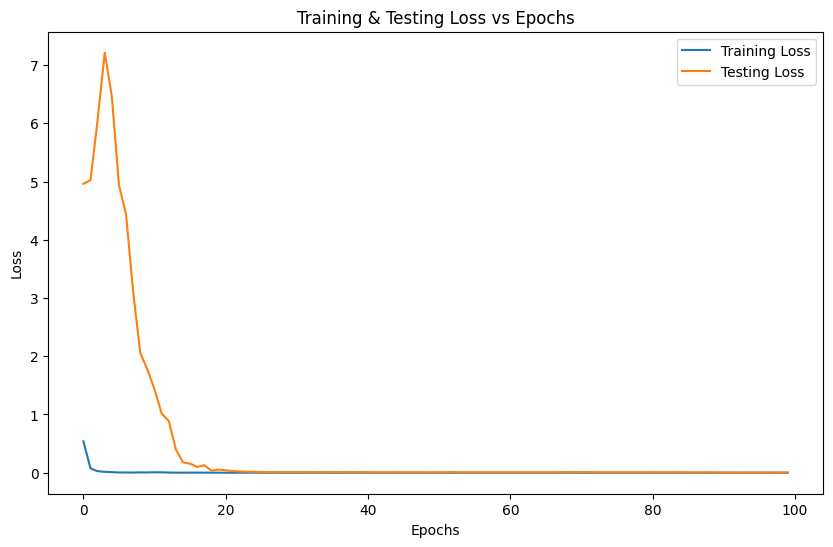

In [105]:
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

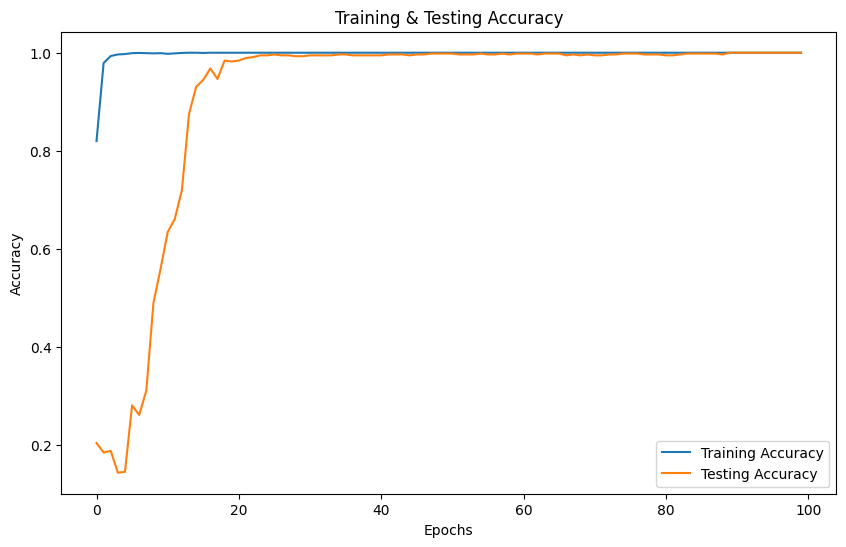

In [106]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

In [107]:
keras.models.load_model(filepath ='/kaggle/working/best_model1_weights.keras')
model.load_weights(filepath ='/kaggle/working/best_model1_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0042
Accuracy of our model on test data :  100.0 %


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


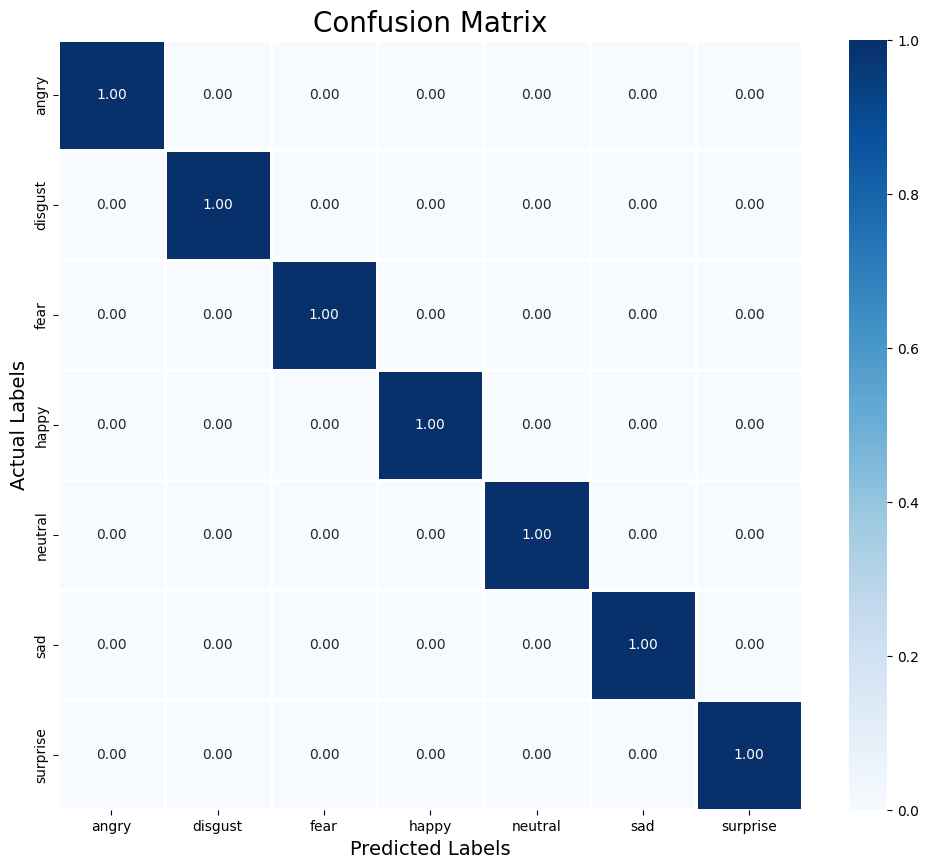

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        80
     disgust       1.00      1.00      1.00        80
        fear       1.00      1.00      1.00        80
       happy       1.00      1.00      1.00        80
     neutral       1.00      1.00      1.00        80
         sad       1.00      1.00      1.00        80
    surprise       1.00      1.00      1.00        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [108]:
# predicting on test data with best model
pred_test1 = model.predict(x_testcnn)
y_pred1 = encoder.inverse_transform(pred_test1)
y_test1 = encoder.inverse_transform(y_test)

from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test1, y_pred1, normalize='true')
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()
print(classification_report(y_test1, y_pred1))